In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import json

In [2]:
# ================================================================
# STEP 1: DATA LOADING AND SETUP FOR NORMAL BEHAVIOR ANALYSIS
# ================================================================

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("STEP 1: LOADING AND PREPARING DATASET IN AZURE")
print("="*60)

# Load the scientific mobility base dataset created in previous step
df = pd.read_csv('scientific_mobility_base_dataset.csv')

# Show basic information about dataset
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Unique Users: {df['user_id'].nunique()}")
print(f"Date Range: Day {df['day'].min()} to Day {df['day'].max()}")

# ================================================================
# SEPARATE NORMAL AND EMERGENCY PERIODS
# ================================================================
print(f"\nSEPARATING NORMAL AND EMERGENCY PERIODS:")

# Normal behavior: Days 0-60
normal_data = df[(df['day'] <= 60) & (df['day'] != 27)].copy()
print(f"Normal Period: {len(normal_data):,} records (Days 0-60)")

# Emergency behavior: Days 61-75  
emergency_data = df[df['day'] >= 61].copy()
print(f"Emergency Period: {len(emergency_data):,} records (Days 61-75)")

# ================================================================
# VERIFY REQUIRED COLUMNS
# ================================================================
print(f"\nCHECKING REQUIRED COLUMNS:")

# Core columns that should exist
required_columns = [
    'user_id',           # User identifier
    'day',               # Day number (0-75)
    'time_slot',         # Time slot (0-47, each 30 minutes)
    'grid_x', 'grid_y',  # Spatial coordinates
]

# Optional enhanced columns (create if missing)
optional_columns = [
    'hour',                      # Hour of day (0-23)
    'is_weekend',               # Weekend indicator
    'distance_from_center',     # Distance from city center
    'location_category',        # POI category
    'poi_density'              # POI density
]

print("Required columns:")
for col in required_columns:
    if col in df.columns:
        print(f"  Available: {col}")
    else:
        print(f"  MISSING: {col}")

print("\nOptional columns (will create if missing):")
for col in optional_columns:
    if col in df.columns:
        print(f"  Available: {col}")
    else:
        print(f"  Will be created: {col}")


STEP 1: LOADING AND PREPARING DATASET IN AZURE
Dataset Shape: (12247358, 21)
Columns: ['user_id', 'day', 'time_slot', 'grid_x', 'grid_y', 'location_category', 'location_function', 'poi_density', 'poi_proportion', 'category_diversity', 'functional_diversity', 'hour', 'time_period_detailed', 'day_of_week', 'day_name', 'is_weekend', 'is_weekday', 'distance_from_center', 'distance_quartile', 'grid_quadrant_name', 'displacement']
Unique Users: 10000
Date Range: Day 0 to Day 74

SEPARATING NORMAL AND EMERGENCY PERIODS:
Normal Period: 9,931,718 records (Days 0-60)
Emergency Period: 2,197,799 records (Days 61-75)

CHECKING REQUIRED COLUMNS:
Required columns:
  Available: user_id
  Available: day
  Available: time_slot
  Available: grid_x
  Available: grid_y

Optional columns (will create if missing):
  Available: hour
  Available: is_weekend
  Available: distance_from_center
  Available: location_category
  Available: poi_density


In [5]:
df['user_id'].unique()

array([   0,    1,    2, ..., 9997, 9998, 9999])

In [6]:
# ================================================================
# CREATE MISSING FEATURES
# ================================================================
print(f"\nCREATING MISSING FEATURES:")

# Create hour from time_slot (each time_slot = 30 minutes)
if 'hour' not in normal_data.columns:
    normal_data['hour'] = (normal_data['time_slot'] * 0.5).astype(int)
    emergency_data['hour'] = (emergency_data['time_slot'] * 0.5).astype(int)
    print("  Created 'hour' from time_slot")

# Create day of week (0=Monday, 6=Sunday)
if 'day_of_week' not in normal_data.columns:
    normal_data['day_of_week'] = normal_data['day'] % 7
    emergency_data['day_of_week'] = emergency_data['day'] % 7
    print("  Created 'day_of_week'")

# Create weekend indicator
if 'is_weekend' not in normal_data.columns:
    normal_data['is_weekend'] = normal_data['day_of_week'] >= 5
    emergency_data['is_weekend'] = emergency_data['day_of_week'] >= 5
    print("  Created 'is_weekend'")

# Create distance from center
if 'distance_from_center' not in normal_data.columns:
    # Use overall dataset to determine center
    center_x = df['grid_x'].median()
    center_y = df['grid_y'].median()
    
    normal_data['distance_from_center'] = np.sqrt(
        (normal_data['grid_x'] - center_x)**2 + 
        (normal_data['grid_y'] - center_y)**2
    )
    emergency_data['distance_from_center'] = np.sqrt(
        (emergency_data['grid_x'] - center_x)**2 + 
        (emergency_data['grid_y'] - center_y)**2
    )
    print(f"  Created 'distance_from_center' (center: {center_x:.1f}, {center_y:.1f})")

# ================================================================
# BASIC DATA OVERVIEW
# ================================================================
print(f"\nBASIC DATA OVERVIEW:")
print(f"Normal Period Summary:")
print(f"  Records: {len(normal_data):,}")
print(f"  Users: {normal_data['user_id'].nunique()}")
print(f"  Days: {normal_data['day'].nunique()}")
print(f"  Unique Locations: {len(normal_data.groupby(['grid_x', 'grid_y']))}")
print(f"  Time Slots: {normal_data['time_slot'].nunique()}")

print(f"\nEmergency Period Summary:")
print(f"  Records: {len(emergency_data):,}")
print(f"  Users: {emergency_data['user_id'].nunique()}")
print(f"  Days: {emergency_data['day'].nunique()}")
print(f"  Unique Locations: {len(emergency_data.groupby(['grid_x', 'grid_y']))}")
print(f"  Time Slots: {emergency_data['time_slot'].nunique()}")



CREATING MISSING FEATURES:

BASIC DATA OVERVIEW:
Normal Period Summary:
  Records: 9,931,718
  Users: 10000
  Days: 60
  Unique Locations: 26627
  Time Slots: 48

Emergency Period Summary:
  Records: 2,197,799
  Users: 10000
  Days: 14
  Unique Locations: 23467
  Time Slots: 48


In [7]:
# ================================================================
# SAVE PREPARED DATA
# ================================================================
print(f"\nSAVING PREPARED DATA:")

# Save the prepared datasets
normal_data.to_csv('normal_behavior_data.csv', index=False)
emergency_data.to_csv('emergency_behavior_data.csv', index=False)

print("  Saved 'normal_behavior_data.csv'")
print("  Saved 'emergency_behavior_data.csv'")

print(f"\nREADY FOR ANALYSIS!")
print(f"Focus: Normal behavior patterns (days 0-60)")

# Show first few rows to verify
print(f"\nSAMPLE DATA:")
print("Normal period sample:")
print(normal_data[['user_id', 'day', 'hour', 'grid_x', 'grid_y', 'distance_from_center']].head())



SAVING PREPARED DATA:
  Saved 'normal_behavior_data.csv'
  Saved 'emergency_behavior_data.csv'

READY FOR ANALYSIS!
Focus: Normal behavior patterns (days 0-60)

SAMPLE DATA:
Normal period sample:
   user_id  day  hour  grid_x  grid_y  distance_from_center
0        0    0     0     163      60             47.107782
1        0    0     0     163      60             47.107782
2        0    0     1     163      61             46.587572
3        0    0     2     163      60             47.107782
4        0    0     4     163      61             46.587572



STEP 2: TEMPORAL PATTERN ANALYSIS - NORMAL BEHAVIOR
Analyzing 9,931,718 records from 10000 users
Period: Days 0 to 60

1. HOURLY ACTIVITY PATTERNS
------------------------------


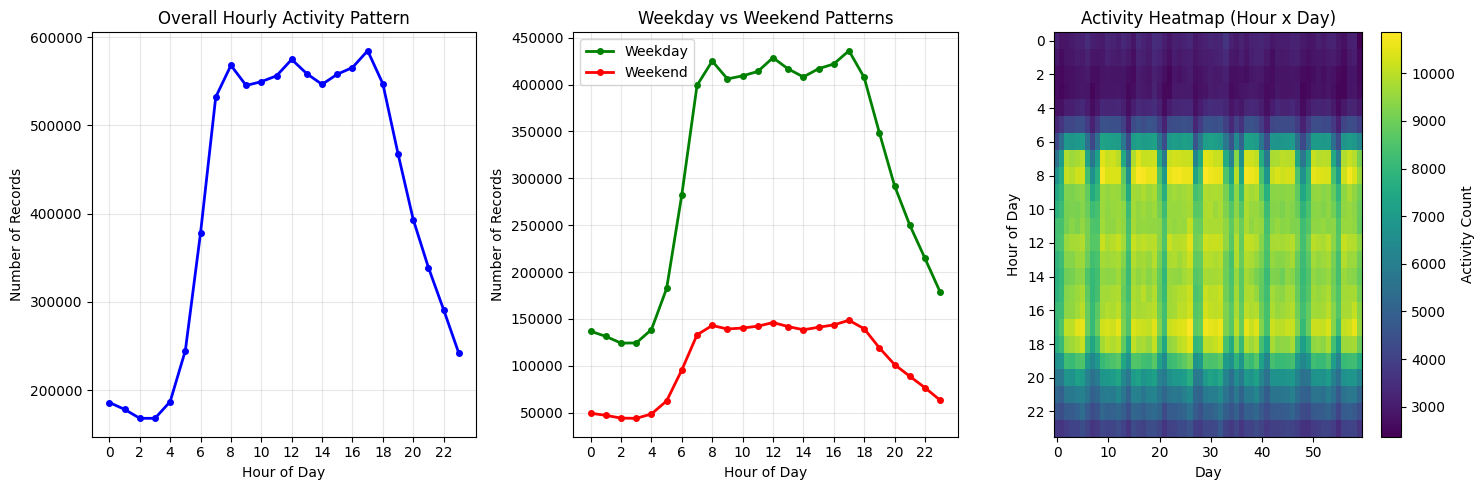

Peak Activity Hour: 17:00 (584,717 records)
Minimum Activity Hour: 3:00 (168,175 records)
Activity Ratio (Peak/Min): 3.5x


In [8]:
# ================================================================
# STEP 2: TEMPORAL PATTERN ANALYSIS - NORMAL BEHAVIOR ONLY
# ================================================================

print("\nSTEP 2: TEMPORAL PATTERN ANALYSIS - NORMAL BEHAVIOR")
print("="*60)
print(f"Analyzing {len(normal_data):,} records from {normal_data['user_id'].nunique()} users")
print(f"Period: Days {normal_data['day'].min()} to {normal_data['day'].max()}")

# ================================================================
# 1. HOURLY ACTIVITY PATTERNS
# ================================================================
print(f"\n1. HOURLY ACTIVITY PATTERNS")
print("-" * 30)

# Calculate hourly activity
hourly_activity = normal_data.groupby('hour').size()
hourly_weekday = normal_data[~normal_data['is_weekend']].groupby('hour').size()
hourly_weekend = normal_data[normal_data['is_weekend']].groupby('hour').size()

# Create visualization
plt.figure(figsize=(15, 5))

# Plot 1: Overall hourly pattern
plt.subplot(1, 3, 1)
plt.plot(hourly_activity.index, hourly_activity.values, 'b-o', linewidth=2, markersize=4)
plt.title('Overall Hourly Activity Pattern')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Records')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Plot 2: Weekday vs Weekend
plt.subplot(1, 3, 2)
plt.plot(hourly_weekday.index, hourly_weekday.values, 'g-o', label='Weekday', linewidth=2, markersize=4)
plt.plot(hourly_weekend.index, hourly_weekend.values, 'r-o', label='Weekend', linewidth=2, markersize=4)
plt.title('Weekday vs Weekend Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Records')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Plot 3: Activity intensity heatmap by hour
plt.subplot(1, 3, 3)
# Create hour activity matrix for heatmap
hour_day_matrix = normal_data.groupby(['hour', 'day']).size().unstack(fill_value=0)
plt.imshow(hour_day_matrix.values, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Activity Count')
plt.title('Activity Heatmap (Hour x Day)')
plt.xlabel('Day')
plt.ylabel('Hour of Day')
plt.yticks(range(0, 24, 2), range(0, 24, 2))

plt.tight_layout()
plt.show()

# Print key findings
peak_hour = hourly_activity.idxmax()
min_hour = hourly_activity.idxmin()
print(f"Peak Activity Hour: {peak_hour}:00 ({hourly_activity.max():,} records)")
print(f"Minimum Activity Hour: {min_hour}:00 ({hourly_activity.min():,} records)")
print(f"Activity Ratio (Peak/Min): {hourly_activity.max()/hourly_activity.min():.1f}x")



2. DAILY ACTIVITY TRENDS
------------------------------


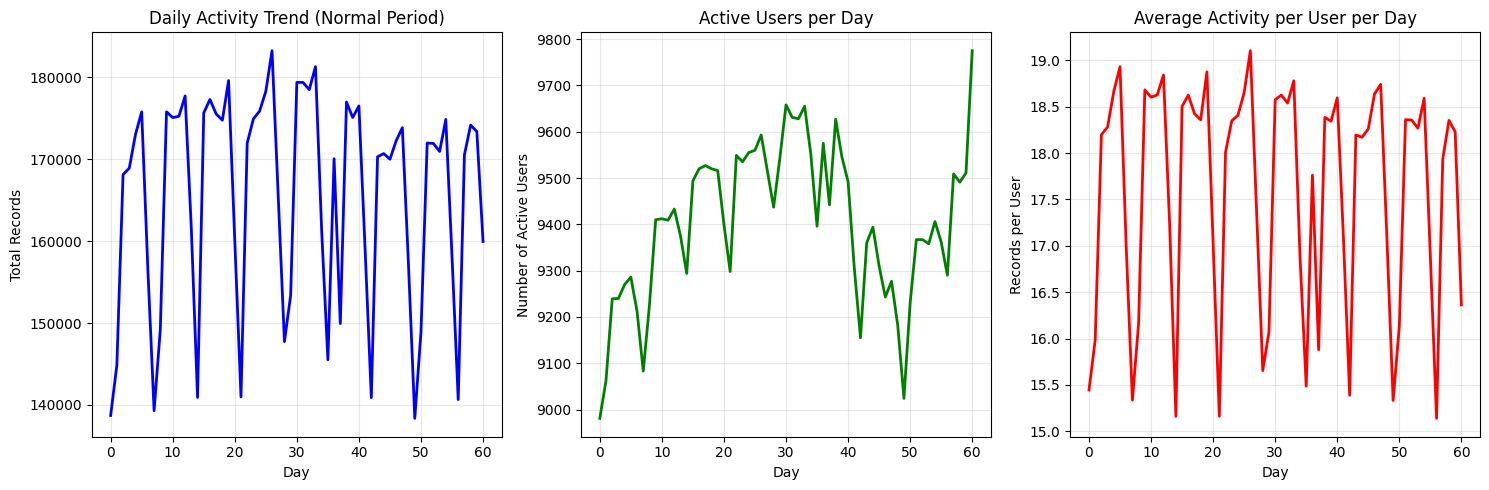

Daily Activity Statistics:
  Average daily records: 165529
  Most active day: Day 26 (183,262 records)
  Least active day: Day 49 (138,356 records)
  Daily activity stability (CV): 0.081

3. WEEKLY PATTERNS
------------------------------


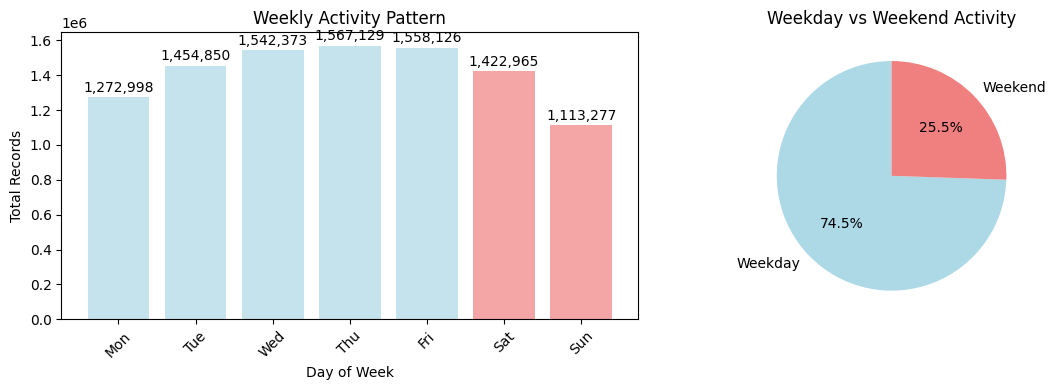

Weekly Pattern Statistics:
  Weekend activity ratio: 25.5%
  Most active day: Thursday (1,567,129 records)
  Least active day: Sunday (1,113,277 records)


In [9]:
# ================================================================
# 2. DAILY ACTIVITY TRENDS
# ================================================================
print(f"\n2. DAILY ACTIVITY TRENDS")
print("-" * 30)

# Calculate daily activity
daily_activity = normal_data.groupby('day').size()
daily_users = normal_data.groupby('day')['user_id'].nunique()

plt.figure(figsize=(15, 5))

# Plot 1: Daily activity trend
plt.subplot(1, 3, 1)
plt.plot(daily_activity.index, daily_activity.values, 'b-', linewidth=2)
plt.title('Daily Activity Trend (Normal Period)')
plt.xlabel('Day')
plt.ylabel('Total Records')
plt.grid(True, alpha=0.3)

# Plot 2: Active users per day
plt.subplot(1, 3, 2)
plt.plot(daily_users.index, daily_users.values, 'g-', linewidth=2)
plt.title('Active Users per Day')
plt.xlabel('Day')
plt.ylabel('Number of Active Users')
plt.grid(True, alpha=0.3)

# Plot 3: Activity per user per day
activity_per_user = daily_activity / daily_users
plt.subplot(1, 3, 3)
plt.plot(activity_per_user.index, activity_per_user.values, 'r-', linewidth=2)
plt.title('Average Activity per User per Day')
plt.xlabel('Day')
plt.ylabel('Records per User')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print daily statistics
print(f"Daily Activity Statistics:")
print(f"  Average daily records: {daily_activity.mean():.0f}")
print(f"  Most active day: Day {daily_activity.idxmax()} ({daily_activity.max():,} records)")
print(f"  Least active day: Day {daily_activity.idxmin()} ({daily_activity.min():,} records)")
print(f"  Daily activity stability (CV): {daily_activity.std()/daily_activity.mean():.3f}")

# ================================================================
# 3. WEEKLY PATTERNS
# ================================================================
print(f"\n3. WEEKLY PATTERNS")
print("-" * 30)

# Calculate weekly patterns
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_activity = normal_data.groupby('day_of_week').size()
weekend_ratio = normal_data['is_weekend'].mean()

plt.figure(figsize=(12, 4))

# Plot 1: Weekly activity pattern
plt.subplot(1, 2, 1)
colors = ['lightblue' if i < 5 else 'lightcoral' for i in range(7)]
bars = plt.bar(range(7), weekly_activity.values, color=colors, alpha=0.7)
plt.title('Weekly Activity Pattern')
plt.xlabel('Day of Week')
plt.ylabel('Total Records')
plt.xticks(range(7), [day[:3] for day in day_names], rotation=45)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

# Plot 2: Weekend vs Weekday comparison
plt.subplot(1, 2, 2)
weekday_activity = weekly_activity[:5].sum()
weekend_activity = weekly_activity[5:].sum()
plt.pie([weekday_activity, weekend_activity], 
        labels=['Weekday', 'Weekend'],
        colors=['lightblue', 'lightcoral'],
        autopct='%1.1f%%',
        startangle=90)
plt.title('Weekday vs Weekend Activity')

plt.tight_layout()
plt.show()

print(f"Weekly Pattern Statistics:")
print(f"  Weekend activity ratio: {weekend_ratio:.1%}")
print(f"  Most active day: {day_names[weekly_activity.idxmax()]} ({weekly_activity.max():,} records)")
print(f"  Least active day: {day_names[weekly_activity.idxmin()]} ({weekly_activity.min():,} records)")


4. TIME SLOT ANALYSIS (30-minute intervals)
------------------------------


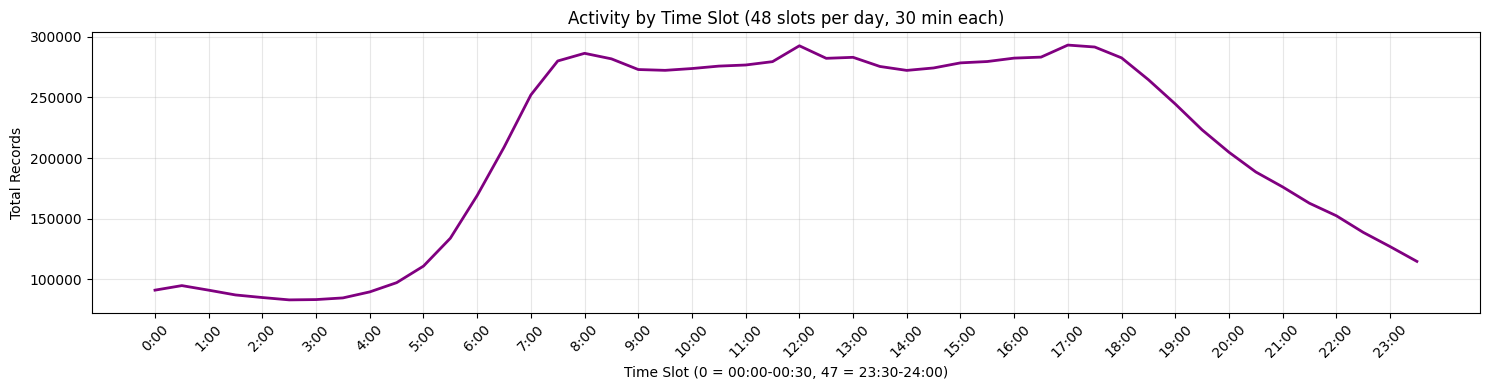

Peak Time Slot: 34 (17:00)
Peak Activity: 293,157 records


In [10]:
# ================================================================
# 4. TIME SLOT ANALYSIS (30-minute intervals)
# ================================================================
print(f"\n4. TIME SLOT ANALYSIS (30-minute intervals)")
print("-" * 30)

# Time slot activity
timeslot_activity = normal_data.groupby('time_slot').size()

plt.figure(figsize=(15, 4))

# Plot time slot activity
plt.plot(timeslot_activity.index, timeslot_activity.values, 'purple', linewidth=2)
plt.title('Activity by Time Slot (48 slots per day, 30 min each)')
plt.xlabel('Time Slot (0 = 00:00-00:30, 47 = 23:30-24:00)')
plt.ylabel('Total Records')
plt.grid(True, alpha=0.3)

# Add hour markers
hour_markers = range(0, 48, 2)  # Every hour
hour_labels = [f"{i//2}:00" for i in hour_markers]
plt.xticks(hour_markers, hour_labels, rotation=45)

plt.tight_layout()
plt.show()

# Peak time slots
peak_timeslot = timeslot_activity.idxmax()
peak_hour = peak_timeslot // 2
peak_minute = (peak_timeslot % 2) * 30

print(f"Peak Time Slot: {peak_timeslot} ({peak_hour:02d}:{peak_minute:02d})")
print(f"Peak Activity: {timeslot_activity.max():,} records")

In [11]:
# ================================================================
# 5. TEMPORAL PATTERN SUMMARY
# ================================================================
print(f"\nTEMPORAL PATTERN SUMMARY - NORMAL BEHAVIOR")
print("=" * 60)

print(f"HOURLY PATTERNS:")
print(f"  Peak hour: {peak_hour}:00 with {hourly_activity.max():,} records")
print(f"  Quiet hour: {min_hour}:00 with {hourly_activity.min():,} records")
print(f"  Activity concentration: {hourly_activity.max()/hourly_activity.min():.1f}x difference")

print(f"\nDAILY PATTERNS:")
print(f"  Total days analyzed: {normal_data['day'].nunique()}")
print(f"  Average daily activity: {daily_activity.mean():.0f} records")
print(f"  Activity stability: {'High' if daily_activity.std()/daily_activity.mean() < 0.2 else 'Moderate'}")

print(f"\nWEEKLY PATTERNS:")
print(f"  Weekend activity proportion: {weekend_ratio:.1%}")
print(f"  Most active day: {day_names[weekly_activity.idxmax()]}")
print(f"  Weekly rhythm strength: {'Strong' if abs(weekday_activity - weekend_activity)/weekday_activity > 0.2 else 'Moderate'}")

print(f"\nKEY INSIGHTS FOR EMERGENCY COMPARISON:")
print(f"  Use {peak_hour}:00 as baseline peak hour")
print(f"  Monitor weekend ratio changes from {weekend_ratio:.3f}")
print(f"  Track daily activity variance from {daily_activity.std():.0f}")
print(f"  Watch for circadian rhythm disruption")

# Save temporal analysis results
temporal_results = {
    'hourly_activity': hourly_activity,
    'daily_activity': daily_activity,
    'weekly_activity': weekly_activity,
    'peak_hour': peak_hour,
    'weekend_ratio': weekend_ratio
}

# Save for next steps
pd.Series(temporal_results['hourly_activity']).to_csv('normal_hourly_pattern.csv')
pd.Series(temporal_results['daily_activity']).to_csv('normal_daily_pattern.csv')


TEMPORAL PATTERN SUMMARY - NORMAL BEHAVIOR
HOURLY PATTERNS:
  Peak hour: 17:00 with 584,717 records
  Quiet hour: 3:00 with 168,175 records
  Activity concentration: 3.5x difference

DAILY PATTERNS:
  Total days analyzed: 60
  Average daily activity: 165529 records
  Activity stability: High

WEEKLY PATTERNS:
  Weekend activity proportion: 25.5%
  Most active day: Thursday
  Weekly rhythm strength: Strong

KEY INSIGHTS FOR EMERGENCY COMPARISON:
  Use 17:00 as baseline peak hour
  Monitor weekend ratio changes from 0.255
  Track daily activity variance from 13457
  Watch for circadian rhythm disruption



STEP 3: SPATIAL PATTERN ANALYSIS - NORMAL BEHAVIOR

1. BASIC SPATIAL DISTRIBUTION
------------------------------
Spatial Extent:
  X range: 1.0 to 200.0
  Y range: 1.0 to 200.0
  Distance from center: 0.1 to 164.9


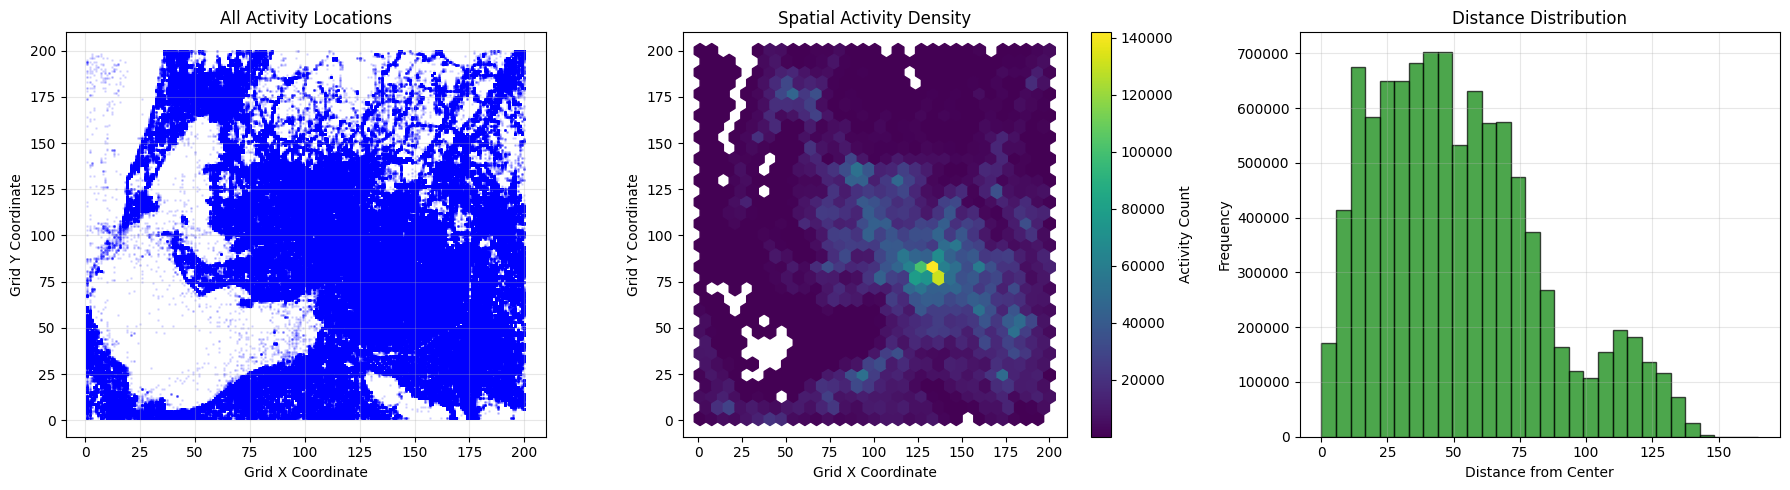


2. LOCATION POPULARITY ANALYSIS
------------------------------
Location Statistics:
  Total unique locations: 26,627
  Most popular location: 24,907 visits
  Most diverse location: 3158 unique visitors


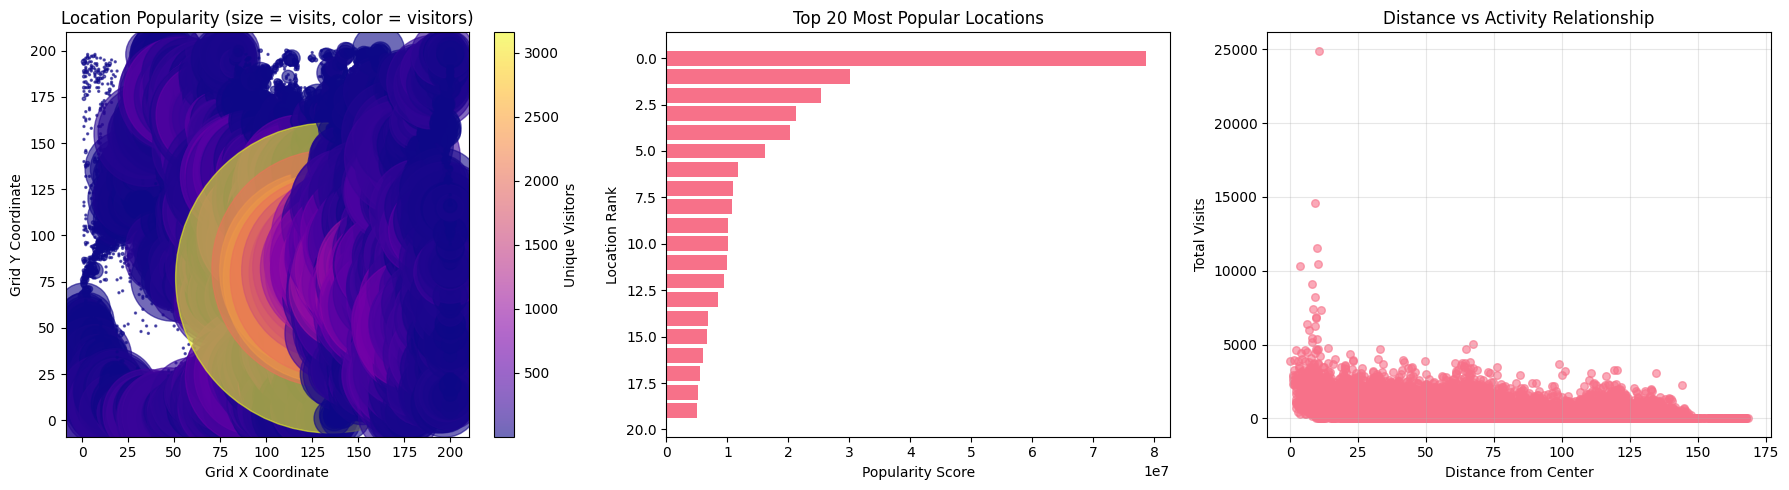


3. DISTANCE ZONES ANALYSIS
------------------------------
Distance Zone Boundaries:
  Central: 0.0 - 27.5 units
  Inner: 27.5 - 47.5 units
  Outer: 47.5 - 70.6 units
  Peripheral: 70.6 - 164.9 units


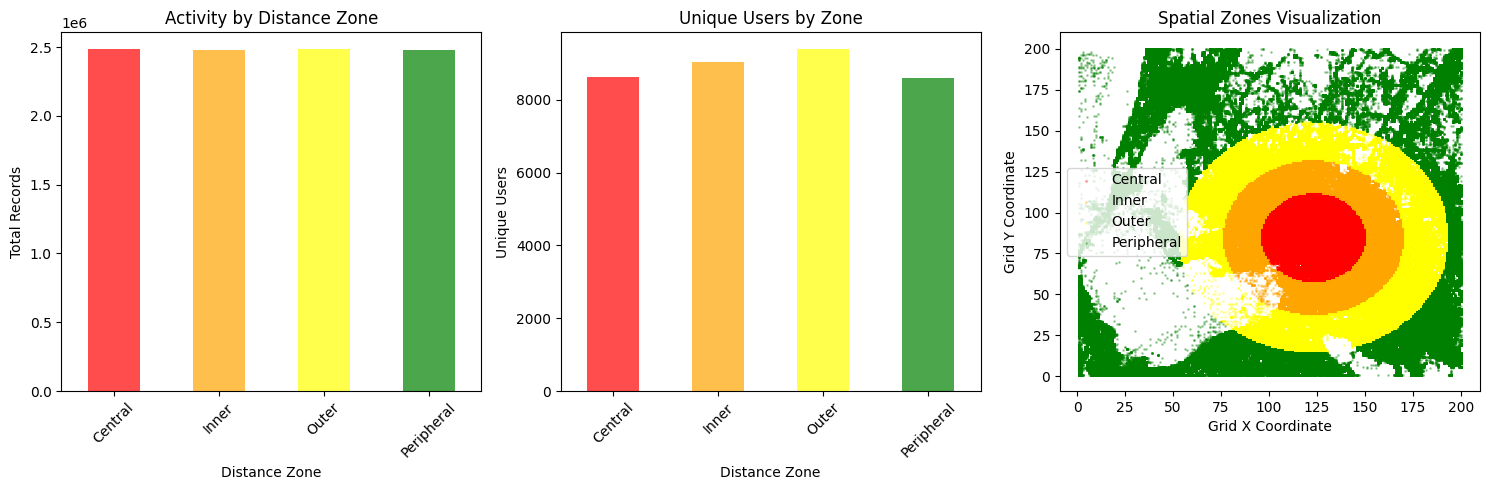

Zone Activity Distribution:
  Central: 2,483,429 records (25.0%) from 8615 users
  Inner: 2,482,752 records (25.0%) from 9046 users
  Outer: 2,482,856 records (25.0%) from 9384 users
  Peripheral: 2,482,681 records (25.0%) from 8598 users


In [12]:
# ================================================================
# STEP 3: SPATIAL PATTERN ANALYSIS - NORMAL BEHAVIOR
# ================================================================

from scipy.spatial.distance import pdist, squareform

print("\nSTEP 3: SPATIAL PATTERN ANALYSIS - NORMAL BEHAVIOR")
print("="*60)

# ================================================================
# 1. BASIC SPATIAL DISTRIBUTION
# ================================================================
print(f"\n1. BASIC SPATIAL DISTRIBUTION")
print("-" * 30)

# Calculate spatial statistics
x_coords = normal_data['grid_x']
y_coords = normal_data['grid_y']
distances = normal_data['distance_from_center']

print(f"Spatial Extent:")
print(f"  X range: {x_coords.min():.1f} to {x_coords.max():.1f}")
print(f"  Y range: {y_coords.min():.1f} to {y_coords.max():.1f}")
print(f"  Distance from center: {distances.min():.1f} to {distances.max():.1f}")

# Create spatial visualizations
plt.figure(figsize=(18, 5))

# Plot 1: Scatter plot of all locations
plt.subplot(1, 3, 1)
plt.scatter(x_coords, y_coords, alpha=0.1, s=1, c='blue')
plt.xlabel('Grid X Coordinate')
plt.ylabel('Grid Y Coordinate')
plt.title('All Activity Locations')
plt.grid(True, alpha=0.3)

# Plot 2: Spatial density (hexbin)
plt.subplot(1, 3, 2)
plt.hexbin(x_coords, y_coords, gridsize=30, cmap='viridis', mincnt=1)
plt.colorbar(label='Activity Count')
plt.xlabel('Grid X Coordinate')
plt.ylabel('Grid Y Coordinate')
plt.title('Spatial Activity Density')

# Plot 3: Distance from center distribution
plt.subplot(1, 3, 3)
plt.hist(distances, bins=30, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Distance from Center')
plt.ylabel('Frequency')
plt.title('Distance Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# 2. LOCATION POPULARITY ANALYSIS
# ================================================================
print(f"\n2. LOCATION POPULARITY ANALYSIS")
print("-" * 30)

# Aggregate activity by location
location_activity = normal_data.groupby(['grid_x', 'grid_y']).agg({
    'user_id': ['count', 'nunique'],  # Total visits and unique visitors
    'day': 'nunique',                 # Days with activity
    'hour': 'nunique'                 # Hours with activity
}).round(2)

# Flatten column names
location_activity.columns = ['total_visits', 'unique_visitors', 'active_days', 'active_hours']
location_activity = location_activity.reset_index()

# Calculate derived metrics
location_activity['visits_per_day'] = location_activity['total_visits'] / location_activity['active_days']
location_activity['visitors_per_day'] = location_activity['unique_visitors'] / location_activity['active_days']
location_activity['popularity_score'] = location_activity['total_visits'] * location_activity['unique_visitors']

# Add distance from center
center_x = normal_data['grid_x'].median()
center_y = normal_data['grid_y'].median()
location_activity['distance_from_center'] = np.sqrt(
    (location_activity['grid_x'] - center_x)**2 + 
    (location_activity['grid_y'] - center_y)**2
)

print(f"Location Statistics:")
print(f"  Total unique locations: {len(location_activity):,}")
print(f"  Most popular location: {location_activity['total_visits'].max():,} visits")
print(f"  Most diverse location: {location_activity['unique_visitors'].max()} unique visitors")

# Visualize location popularity
plt.figure(figsize=(18, 5))

# Plot 1: Popularity map (bubble chart)
plt.subplot(1, 3, 1)
plt.scatter(location_activity['grid_x'], location_activity['grid_y'], 
           s=location_activity['total_visits']*2, 
           c=location_activity['unique_visitors'], 
           alpha=0.6, cmap='plasma')
plt.colorbar(label='Unique Visitors')
plt.xlabel('Grid X Coordinate')
plt.ylabel('Grid Y Coordinate')
plt.title('Location Popularity (size = visits, color = visitors)')

# Plot 2: Top locations
top_locations = location_activity.nlargest(20, 'popularity_score')
plt.subplot(1, 3, 2)
plt.barh(range(len(top_locations)), top_locations['popularity_score'])
plt.ylabel('Location Rank')
plt.xlabel('Popularity Score')
plt.title('Top 20 Most Popular Locations')
plt.gca().invert_yaxis()

# Plot 3: Distance vs Popularity
plt.subplot(1, 3, 3)
plt.scatter(location_activity['distance_from_center'], location_activity['total_visits'], 
           alpha=0.6, s=30)
plt.xlabel('Distance from Center')
plt.ylabel('Total Visits')
plt.title('Distance vs Activity Relationship')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# 3. DISTANCE ZONES ANALYSIS
# ================================================================
print(f"\n3. DISTANCE ZONES ANALYSIS")
print("-" * 30)

# Create distance quartiles
distance_quartiles = pd.qcut(normal_data['distance_from_center'], 
                           q=4, labels=['Central', 'Inner', 'Outer', 'Peripheral'])

# Analyze activity by zone
zone_activity = normal_data.groupby(distance_quartiles).agg({
    'user_id': ['count', 'nunique'],
    'day': 'nunique',
    'hour': 'nunique'
})

zone_activity.columns = ['total_records', 'unique_users', 'active_days', 'active_hours']
zone_stats = zone_activity.copy()

# Calculate zone boundaries
zone_boundaries = pd.qcut(normal_data['distance_from_center'], q=4, retbins=True)[1]

print(f"Distance Zone Boundaries:")
for i, (zone, boundary) in enumerate(zip(['Central', 'Inner', 'Outer', 'Peripheral'], zone_boundaries[1:])):
    start = zone_boundaries[i] if i > 0 else 0
    print(f"  {zone}: {start:.1f} - {boundary:.1f} units")

# Visualize zones
plt.figure(figsize=(15, 5))

# Plot 1: Zone activity
plt.subplot(1, 3, 1)
zone_activity['total_records'].plot(kind='bar', color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
plt.title('Activity by Distance Zone')
plt.xlabel('Distance Zone')
plt.ylabel('Total Records')
plt.xticks(rotation=45)

# Plot 2: Users by zone
plt.subplot(1, 3, 2)
zone_activity['unique_users'].plot(kind='bar', color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
plt.title('Unique Users by Zone')
plt.xlabel('Distance Zone')
plt.ylabel('Unique Users')
plt.xticks(rotation=45)

# Plot 3: Zone map
plt.subplot(1, 3, 3)
# Create zone colors for visualization
zone_colors = {'Central': 'red', 'Inner': 'orange', 'Outer': 'yellow', 'Peripheral': 'green'}
for zone in ['Central', 'Inner', 'Outer', 'Peripheral']:
    zone_data = normal_data[distance_quartiles == zone]
    plt.scatter(zone_data['grid_x'], zone_data['grid_y'], 
               c=zone_colors[zone], alpha=0.3, s=1, label=zone)

plt.xlabel('Grid X Coordinate')
plt.ylabel('Grid Y Coordinate')
plt.title('Spatial Zones Visualization')
plt.legend()

plt.tight_layout()
plt.show()

# Print zone statistics
print(f"Zone Activity Distribution:")
for zone in ['Central', 'Inner', 'Outer', 'Peripheral']:
    records = zone_stats.loc[zone, 'total_records']
    users = zone_stats.loc[zone, 'unique_users']
    percentage = records / zone_stats['total_records'].sum() * 100
    print(f"  {zone}: {records:,} records ({percentage:.1f}%) from {users} users")

In [13]:
# ================================================================
# SAVE SPATIAL ANALYSIS RESULTS
# ================================================================

# Save spatial analysis results
spatial_results = {
    'location_activity': location_activity,
    'zone_boundaries': zone_boundaries,
    'center_coords': (center_x, center_y)
}

# Save key results for next steps
location_activity.to_csv('normal_location_activity.csv', index=False)

print("\nSpatial analysis results saved!")

# ================================================================
# STEP 4: USER BEHAVIOR ANALYSIS - NORMAL BEHAVIOR
# ================================================================

print("\nSTEP 4: USER BEHAVIOR ANALYSIS - NORMAL BEHAVIOR")
print("="*60)

# ================================================================
# 1. CREATE USER PROFILES
# ================================================================
print(f"\n1. CREATING INDIVIDUAL USER PROFILES")
print("-" * 30)

# Aggregate user-level metrics
user_profiles = normal_data.groupby('user_id').agg({
    'day': 'nunique',                    # active_days
    'time_slot': 'count',                # total_records
    'hour': 'nunique',                   # temporal_diversity
    'grid_x': ['std', 'nunique', 'mean'], # spatial_metrics
    'grid_y': ['std', 'nunique', 'mean'], # spatial_metrics
    'distance_from_center': ['mean', 'max', 'std'], # distance_metrics
    'is_weekend': 'mean',                # weekend_activity_ratio
}).round(3)

# Flatten column names
user_profiles.columns = ['active_days', 'total_records', 'temporal_diversity',
                        'x_std', 'x_locations', 'x_mean',
                        'y_std', 'y_locations', 'y_mean', 
                        'avg_distance', 'max_distance', 'distance_std',
                        'weekend_ratio']

# Calculate derived metrics
user_profiles['activity_intensity'] = user_profiles['total_records'] / user_profiles['active_days']
user_profiles['mobility_radius'] = np.sqrt(user_profiles['x_std']**2 + user_profiles['y_std']**2)
user_profiles['spatial_coverage'] = user_profiles['x_locations'] * user_profiles['y_locations']
user_profiles['distance_range'] = user_profiles['max_distance'] - user_profiles['avg_distance']

# Handle NaN values (users with only one location)
user_profiles = user_profiles.fillna(0)

print(f"User Profile Statistics:")
print(f"  Users analyzed: {len(user_profiles)}")
print(f"  Average active days: {user_profiles['active_days'].mean():.1f}")
print(f"  Average total records: {user_profiles['total_records'].mean():.0f}")
print(f"  Average activity intensity: {user_profiles['activity_intensity'].mean():.1f} records/day")

# Display sample user profiles
print(f"\nSample User Profiles:")
sample_users = user_profiles.sample(5)
for user_id, profile in sample_users.iterrows():
    print(f"  User {user_id}: {profile['total_records']:.0f} records, "
          f"{profile['active_days']:.0f} days, "
          f"intensity {profile['activity_intensity']:.1f}, "
          f"mobility {profile['mobility_radius']:.1f}")



Spatial analysis results saved!

STEP 4: USER BEHAVIOR ANALYSIS - NORMAL BEHAVIOR

1. CREATING INDIVIDUAL USER PROFILES
------------------------------
User Profile Statistics:
  Users analyzed: 10000
  Average active days: 56.4
  Average total records: 993
  Average activity intensity: 17.6 records/day

Sample User Profiles:
  User 94: 910 records, 51 days, intensity 17.8, mobility 35.6
  User 1303: 1076 records, 56 days, intensity 19.2, mobility 42.6
  User 622: 710 records, 58 days, intensity 12.2, mobility 3.5
  User 3022: 1015 records, 57 days, intensity 17.8, mobility 39.3
  User 5638: 792 records, 57 days, intensity 13.9, mobility 23.0



2. USER CLUSTERING ANALYSIS
------------------------------
User Clusters (k=4):

  Cluster 0 (2282 users):
    Activity Intensity: 25.5
    Mobility Radius: 13.35
    Spatial Coverage: 2299.0
    Weekend Ratio: 0.250
    Temporal Diversity: 23.9

  Cluster 1 (1650 users):
    Activity Intensity: 14.1
    Mobility Radius: 18.54
    Spatial Coverage: 3024.9
    Weekend Ratio: 0.260
    Temporal Diversity: 19.2

  Cluster 2 (1743 users):
    Activity Intensity: 17.4
    Mobility Radius: 37.78
    Spatial Coverage: 10055.8
    Weekend Ratio: 0.260
    Temporal Diversity: 23.2

  Cluster 3 (4325 users):
    Activity Intensity: 14.9
    Mobility Radius: 16.68
    Spatial Coverage: 2482.3
    Weekend Ratio: 0.260
    Temporal Diversity: 23.7


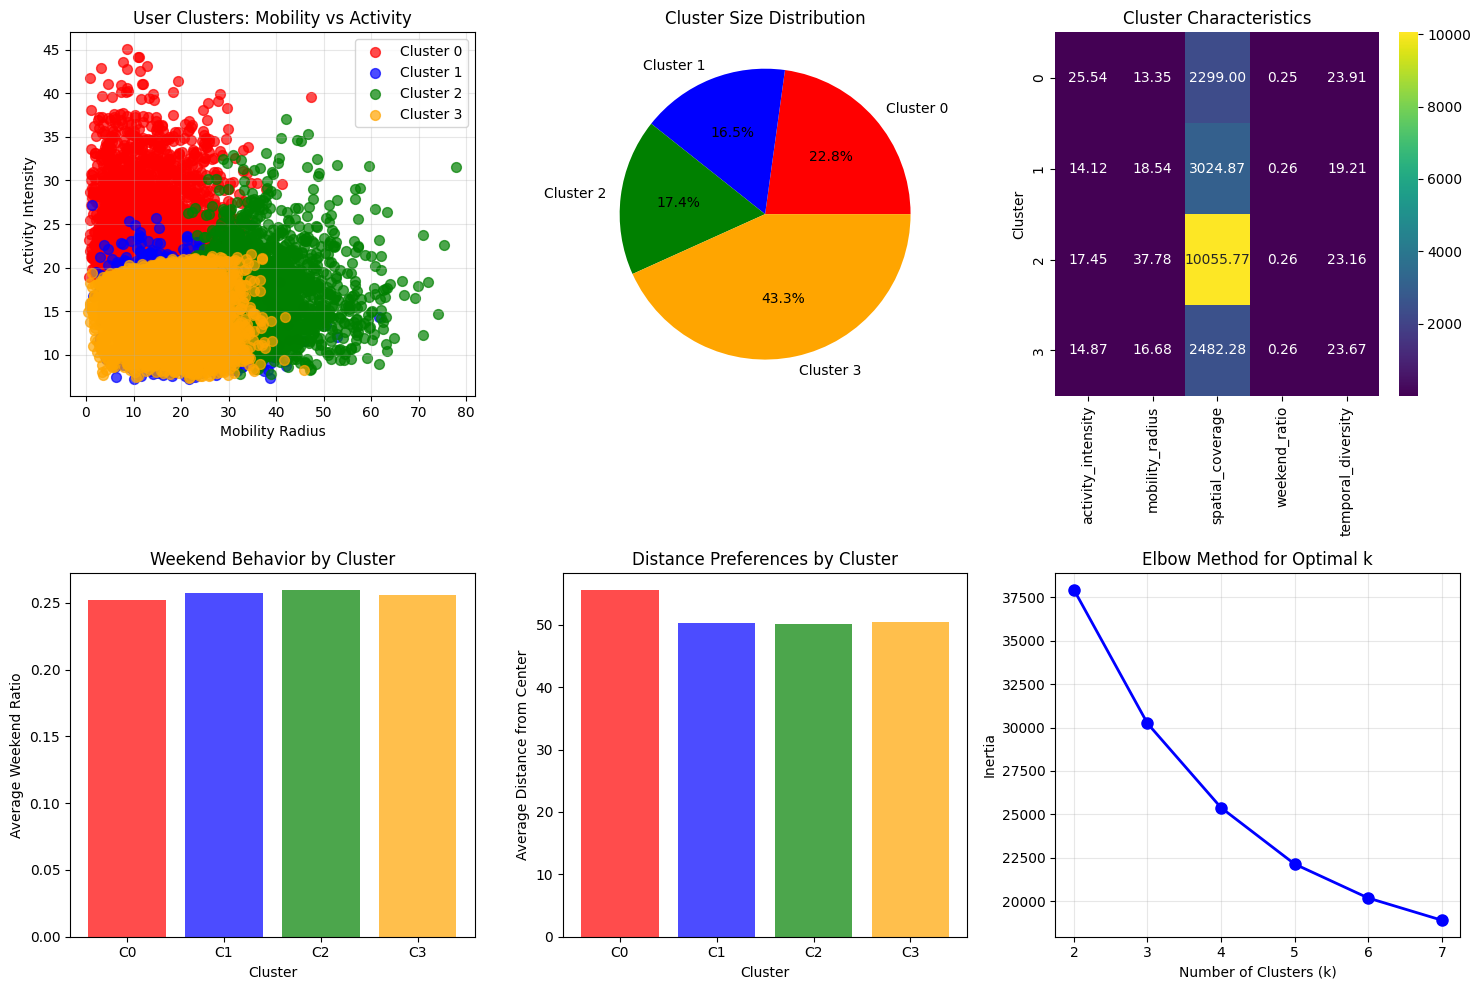

In [14]:
# ================================================================
# 2. USER CLUSTERING ANALYSIS
# ================================================================
print(f"\n2. USER CLUSTERING ANALYSIS")
print("-" * 30)

# Select features for clustering
clustering_features = ['activity_intensity', 'mobility_radius', 'spatial_coverage', 
                      'weekend_ratio', 'temporal_diversity']

cluster_data = user_profiles[clustering_features].copy()

# Standardize features
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
inertias = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_scaled)
    inertias.append(kmeans.inertia_)
# Use 4 clusters for interpretation
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_profiles['cluster'] = kmeans.fit_predict(cluster_data_scaled)

print(f"User Clusters (k={optimal_k}):")

# Analyze each cluster
cluster_summary = user_profiles.groupby('cluster')[clustering_features].mean().round(2)
cluster_counts = user_profiles['cluster'].value_counts().sort_index()

for cluster_id in range(optimal_k):
    count = cluster_counts[cluster_id]
    summary = cluster_summary.loc[cluster_id]
    print(f"\n  Cluster {cluster_id} ({count} users):")
    print(f"    Activity Intensity: {summary['activity_intensity']:.1f}")
    print(f"    Mobility Radius: {summary['mobility_radius']:.2f}")
    print(f"    Spatial Coverage: {summary['spatial_coverage']:.1f}")
    print(f"    Weekend Ratio: {summary['weekend_ratio']:.3f}")
    print(f"    Temporal Diversity: {summary['temporal_diversity']:.1f}")

# Visualize clusters
plt.figure(figsize=(15, 10))

# Plot 1: Cluster visualization (Activity vs Mobility)
plt.subplot(2, 3, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple']
for cluster_id in range(optimal_k):
    cluster_users = user_profiles[user_profiles['cluster'] == cluster_id]
    plt.scatter(cluster_users['mobility_radius'], cluster_users['activity_intensity'], 
               c=colors[cluster_id], label=f'Cluster {cluster_id}', alpha=0.7, s=50)
plt.xlabel('Mobility Radius')
plt.ylabel('Activity Intensity')
plt.title('User Clusters: Mobility vs Activity')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cluster sizes
plt.subplot(2, 3, 2)
plt.pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index], 
        autopct='%1.1f%%', colors=colors[:optimal_k])
plt.title('Cluster Size Distribution')

# Plot 3: Cluster characteristics heatmap
plt.subplot(2, 3, 3)
sns.heatmap(cluster_summary, annot=True, cmap='viridis', fmt='.2f')
plt.title('Cluster Characteristics')
plt.ylabel('Cluster')

# Plot 4: Weekend behavior by cluster
plt.subplot(2, 3, 4)
cluster_weekend = user_profiles.groupby('cluster')['weekend_ratio'].mean()
plt.bar(range(optimal_k), cluster_weekend.values, color=colors[:optimal_k], alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Average Weekend Ratio')
plt.title('Weekend Behavior by Cluster')
plt.xticks(range(optimal_k), [f'C{i}' for i in range(optimal_k)])

# Plot 5: Distance preferences by cluster
plt.subplot(2, 3, 5)
cluster_distance = user_profiles.groupby('cluster')['avg_distance'].mean()
plt.bar(range(optimal_k), cluster_distance.values, color=colors[:optimal_k], alpha=0.7)
plt.xlabel('Cluster')
plt.ylabel('Average Distance from Center')
plt.title('Distance Preferences by Cluster')
plt.xticks(range(optimal_k), [f'C{i}' for i in range(optimal_k)])

# Plot 6: Elbow curve for cluster selection
plt.subplot(2, 3, 6)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# ================================================================
# 3. SAVE USER PROFILES FOR NEXT STEPS
# ================================================================
print(f"\nSAVING USER BEHAVIOR ANALYSIS RESULTS:")

# Save comprehensive user profiles
user_profiles.to_csv('normal_user_profiles.csv')

# Save cluster assignments
cluster_results = pd.DataFrame({
    'user_id': user_profiles.index,
    'cluster': user_profiles['cluster'],
    'activity_intensity': user_profiles['activity_intensity'],
    'mobility_radius': user_profiles['mobility_radius']
})
cluster_results.to_csv('normal_user_clusters.csv', index=False)

print(f"  Saved 'normal_user_profiles.csv' - Complete user behavior profiles")
print(f"  Saved 'normal_user_clusters.csv' - User cluster assignments")

print(f"\nSTEP 4 COMPLETE!")
print(f"User behavior patterns established for {len(user_profiles)} users")
print(f"{optimal_k} distinct user types identified")


SAVING USER BEHAVIOR ANALYSIS RESULTS:
  Saved 'normal_user_profiles.csv' - Complete user behavior profiles
  Saved 'normal_user_clusters.csv' - User cluster assignments

STEP 4 COMPLETE!
User behavior patterns established for 10000 users
4 distinct user types identified



STEP 5: EMERGENCY vs NORMAL BEHAVIOR COMPARISON

1. TEMPORAL PATTERN COMPARISON
------------------------------
HOURLY PATTERN CHANGES:
  Normal peak hour: 17:00 (9745.3 avg records)
  Emergency peak hour: 17:00 (9327.6 avg records)
  Peak hour shift: 0 hours
  Peak activity change: -4.3%


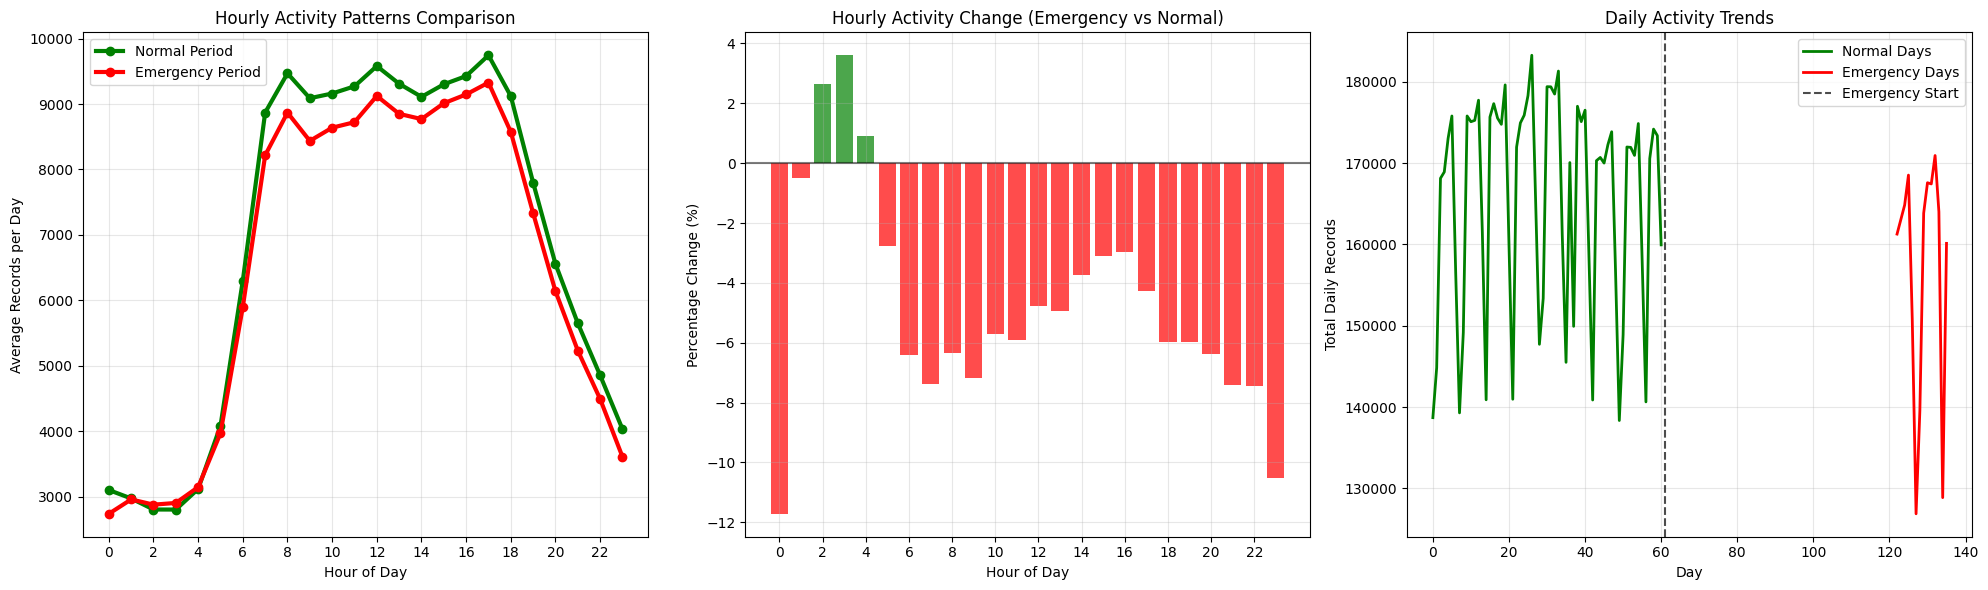

Hourly Pattern T-test: t=0.467, p=0.642595
Weekend Activity Changes:
  Normal weekend ratio: 0.255
  Emergency weekend ratio: 0.298
  Change: 0.043 (16.8%)


In [16]:
# ================================================================
# STEP 5: EMERGENCY vs NORMAL COMPARISON ANALYSIS
# ================================================================

print("\nSTEP 5: EMERGENCY vs NORMAL BEHAVIOR COMPARISON")
print("="*60)

# ================================================================
# 1. TEMPORAL COMPARISON
# ================================================================
print(f"\n1. TEMPORAL PATTERN COMPARISON")
print("-" * 30)

# Calculate hourly patterns for both periods
normal_hourly = normal_data.groupby('hour').size()
emergency_hourly = emergency_data.groupby('hour').size()

# Normalize by number of days for fair comparison
normal_days = normal_data['day'].nunique()
emergency_days = emergency_data['day'].nunique()

normal_hourly_avg = normal_hourly / normal_days
emergency_hourly_avg = emergency_hourly / emergency_days

# Calculate percentage change
hourly_change = ((emergency_hourly_avg - normal_hourly_avg) / normal_hourly_avg * 100).fillna(0)

# Peak hour analysis
normal_peak = normal_hourly_avg.idxmax()
emergency_peak = emergency_hourly_avg.idxmax()
peak_shift = emergency_peak - normal_peak

print(f"HOURLY PATTERN CHANGES:")
print(f"  Normal peak hour: {normal_peak}:00 ({normal_hourly_avg.max():.1f} avg records)")
print(f"  Emergency peak hour: {emergency_peak}:00 ({emergency_hourly_avg.max():.1f} avg records)")
print(f"  Peak hour shift: {peak_shift} hours")
print(f"  Peak activity change: {((emergency_hourly_avg.max() - normal_hourly_avg.max())/normal_hourly_avg.max()*100):.1f}%")

# Visualize temporal comparison
plt.figure(figsize=(20, 6))

# Plot 1: Hourly pattern overlay
plt.subplot(1, 3, 1)
plt.plot(normal_hourly_avg.index, normal_hourly_avg.values, 'g-o', linewidth=3, 
         markersize=6, label='Normal Period')
plt.plot(emergency_hourly_avg.index, emergency_hourly_avg.values, 'r-o', linewidth=3, 
         markersize=6, label='Emergency Period')
plt.xlabel('Hour of Day')
plt.ylabel('Average Records per Day')
plt.title('Hourly Activity Patterns Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Plot 2: Percentage change by hour
plt.subplot(1, 3, 2)
colors = ['red' if x < 0 else 'green' for x in hourly_change.values]
bars = plt.bar(hourly_change.index, hourly_change.values, color=colors, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Hour of Day')
plt.ylabel('Percentage Change (%)')
plt.title('Hourly Activity Change (Emergency vs Normal)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))

# Add percentage labels on significant changes
for i, (hour, change) in enumerate(hourly_change.items()):
    if abs(change) > 20:  # Only label significant changes
        plt.text(hour, change + (5 if change > 0 else -5), f'{change:.0f}%', 
                ha='center', va='bottom' if change > 0 else 'top', fontsize=8)

# Plot 3: Daily trend comparison
plt.subplot(1, 3, 3)
normal_daily = normal_data.groupby('day').size()
emergency_daily = emergency_data.groupby('day').size()

plt.plot(normal_daily.index, normal_daily.values, 'g-', linewidth=2, label='Normal Days')
plt.plot(emergency_daily.index + 61, emergency_daily.values, 'r-', linewidth=2, label='Emergency Days')
plt.axvline(x=61, color='black', linestyle='--', alpha=0.7, label='Emergency Start')
plt.xlabel('Day')
plt.ylabel('Total Daily Records')
plt.title('Daily Activity Trends')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test for hourly differences
t_stat, p_value = stats.ttest_ind(normal_hourly_avg, emergency_hourly_avg)
print(f"Hourly Pattern T-test: t={t_stat:.3f}, p={p_value:.6f}")

# Weekend activity comparison
normal_weekend_ratio = normal_data['is_weekend'].mean()
emergency_weekend_ratio = emergency_data['is_weekend'].mean()
weekend_change = emergency_weekend_ratio - normal_weekend_ratio

print(f"Weekend Activity Changes:")
print(f"  Normal weekend ratio: {normal_weekend_ratio:.3f}")
print(f"  Emergency weekend ratio: {emergency_weekend_ratio:.3f}")
print(f"  Change: {weekend_change:.3f} ({weekend_change/normal_weekend_ratio*100:.1f}%)")



2. SPATIAL PATTERN COMPARISON
------------------------------
SPATIAL CHANGES:
  Normal avg distance: 52.12
  Emergency avg distance: 52.36
  Distance change: 0.24 (0.5%)
  Spread change: 0.00
LOCATION CHANGES:
  Common locations: 22650
  New emergency locations: 817
  Abandoned locations: 3977
  Location stability: 85.1%


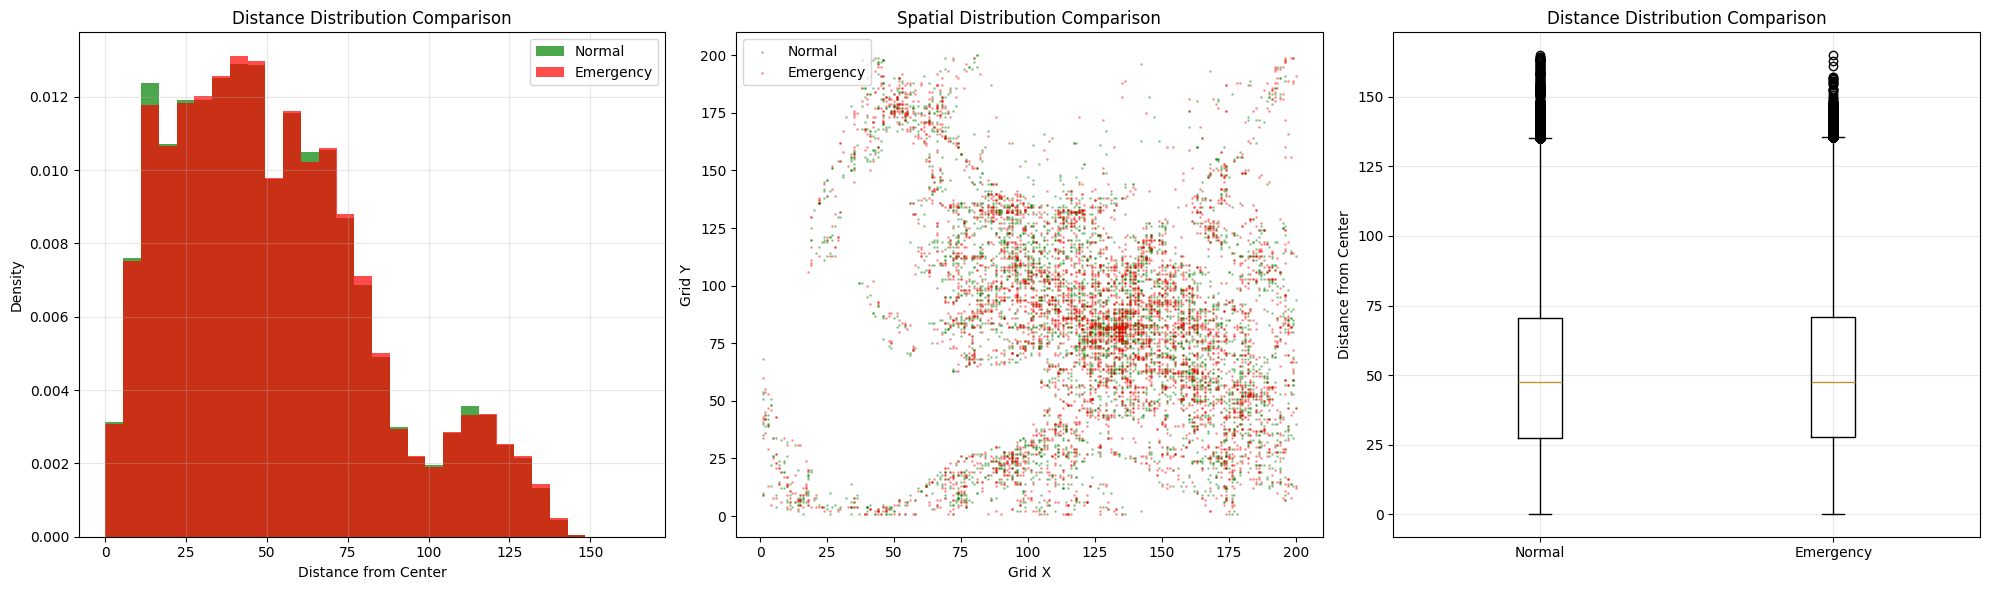

Spatial Distribution Mann-Whitney U: U=10861814249999, p=0.000000


In [17]:
# ================================================================
# 2. SPATIAL COMPARISON
# ================================================================
print(f"\n2. SPATIAL PATTERN COMPARISON")
print("-" * 30)

# Distance from center analysis
normal_distances = normal_data['distance_from_center']
emergency_distances = emergency_data['distance_from_center']

distance_change = emergency_distances.mean() - normal_distances.mean()
distance_spread_change = emergency_distances.std() - normal_distances.std()

print(f"SPATIAL CHANGES:")
print(f"  Normal avg distance: {normal_distances.mean():.2f}")
print(f"  Emergency avg distance: {emergency_distances.mean():.2f}")
print(f"  Distance change: {distance_change:.2f} ({distance_change/normal_distances.mean()*100:.1f}%)")
print(f"  Spread change: {distance_spread_change:.2f}")

# Location analysis
normal_locations = set(zip(normal_data['grid_x'], normal_data['grid_y']))
emergency_locations = set(zip(emergency_data['grid_x'], emergency_data['grid_y']))

common_locations = len(normal_locations & emergency_locations)
new_emergency_locations = len(emergency_locations - normal_locations)
abandoned_locations = len(normal_locations - emergency_locations)

print(f"LOCATION CHANGES:")
print(f"  Common locations: {common_locations}")
print(f"  New emergency locations: {new_emergency_locations}")
print(f"  Abandoned locations: {abandoned_locations}")
print(f"  Location stability: {common_locations/len(normal_locations)*100:.1f}%")

# Visualize spatial comparison
plt.figure(figsize=(20, 6))

# Plot 1: Distance distribution comparison
plt.subplot(1, 3, 1)
plt.hist(normal_distances, bins=30, alpha=0.7, label='Normal', color='green', density=True)
plt.hist(emergency_distances, bins=30, alpha=0.7, label='Emergency', color='red', density=True)
plt.xlabel('Distance from Center')
plt.ylabel('Density')
plt.title('Distance Distribution Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Spatial activity comparison (sample for visualization)
plt.subplot(1, 3, 2)
normal_sample = normal_data.sample(min(5000, len(normal_data)))
emergency_sample = emergency_data.sample(min(5000, len(emergency_data)))

plt.scatter(normal_sample['grid_x'], normal_sample['grid_y'], 
           c='green', alpha=0.3, s=1, label='Normal')
plt.scatter(emergency_sample['grid_x'], emergency_sample['grid_y'], 
           c='red', alpha=0.3, s=1, label='Emergency')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.title('Spatial Distribution Comparison')
plt.legend()

# Plot 3: Box plot comparison
plt.subplot(1, 3, 3)
plt.boxplot([normal_distances, emergency_distances], 
           labels=['Normal', 'Emergency'])
plt.ylabel('Distance from Center')
plt.title('Distance Distribution Comparison')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test for spatial differences
u_stat, p_spatial = stats.mannwhitneyu(normal_distances, emergency_distances, alternative='two-sided')
print(f"Spatial Distribution Mann-Whitney U: U={u_stat:.0f}, p={p_spatial:.6f}")


3. USER BEHAVIOR COMPARISON
------------------------------
Users present in both periods: 10000
USER BEHAVIOR CHANGES (Common Users):
  Activity Intensity:
    Normal: 17.63 → Emergency: 16.03
    Change: -1.60 (-9.1%)
  Mobility Radius:
    Normal: 19.90 → Emergency: 18.47
    Change: -1.43 (-7.2%)
  Spatial Coverage:
    Normal: 3850.04 → Emergency: 1162.56
    Change: -2687.48 (-69.8%)
  Avg Distance:
    Normal: 51.53 → Emergency: 51.86
    Change: 0.33 (0.6%)
  Weekend Ratio:
    Normal: 0.26 → Emergency: 0.30
    Change: 0.04 (17.2%)


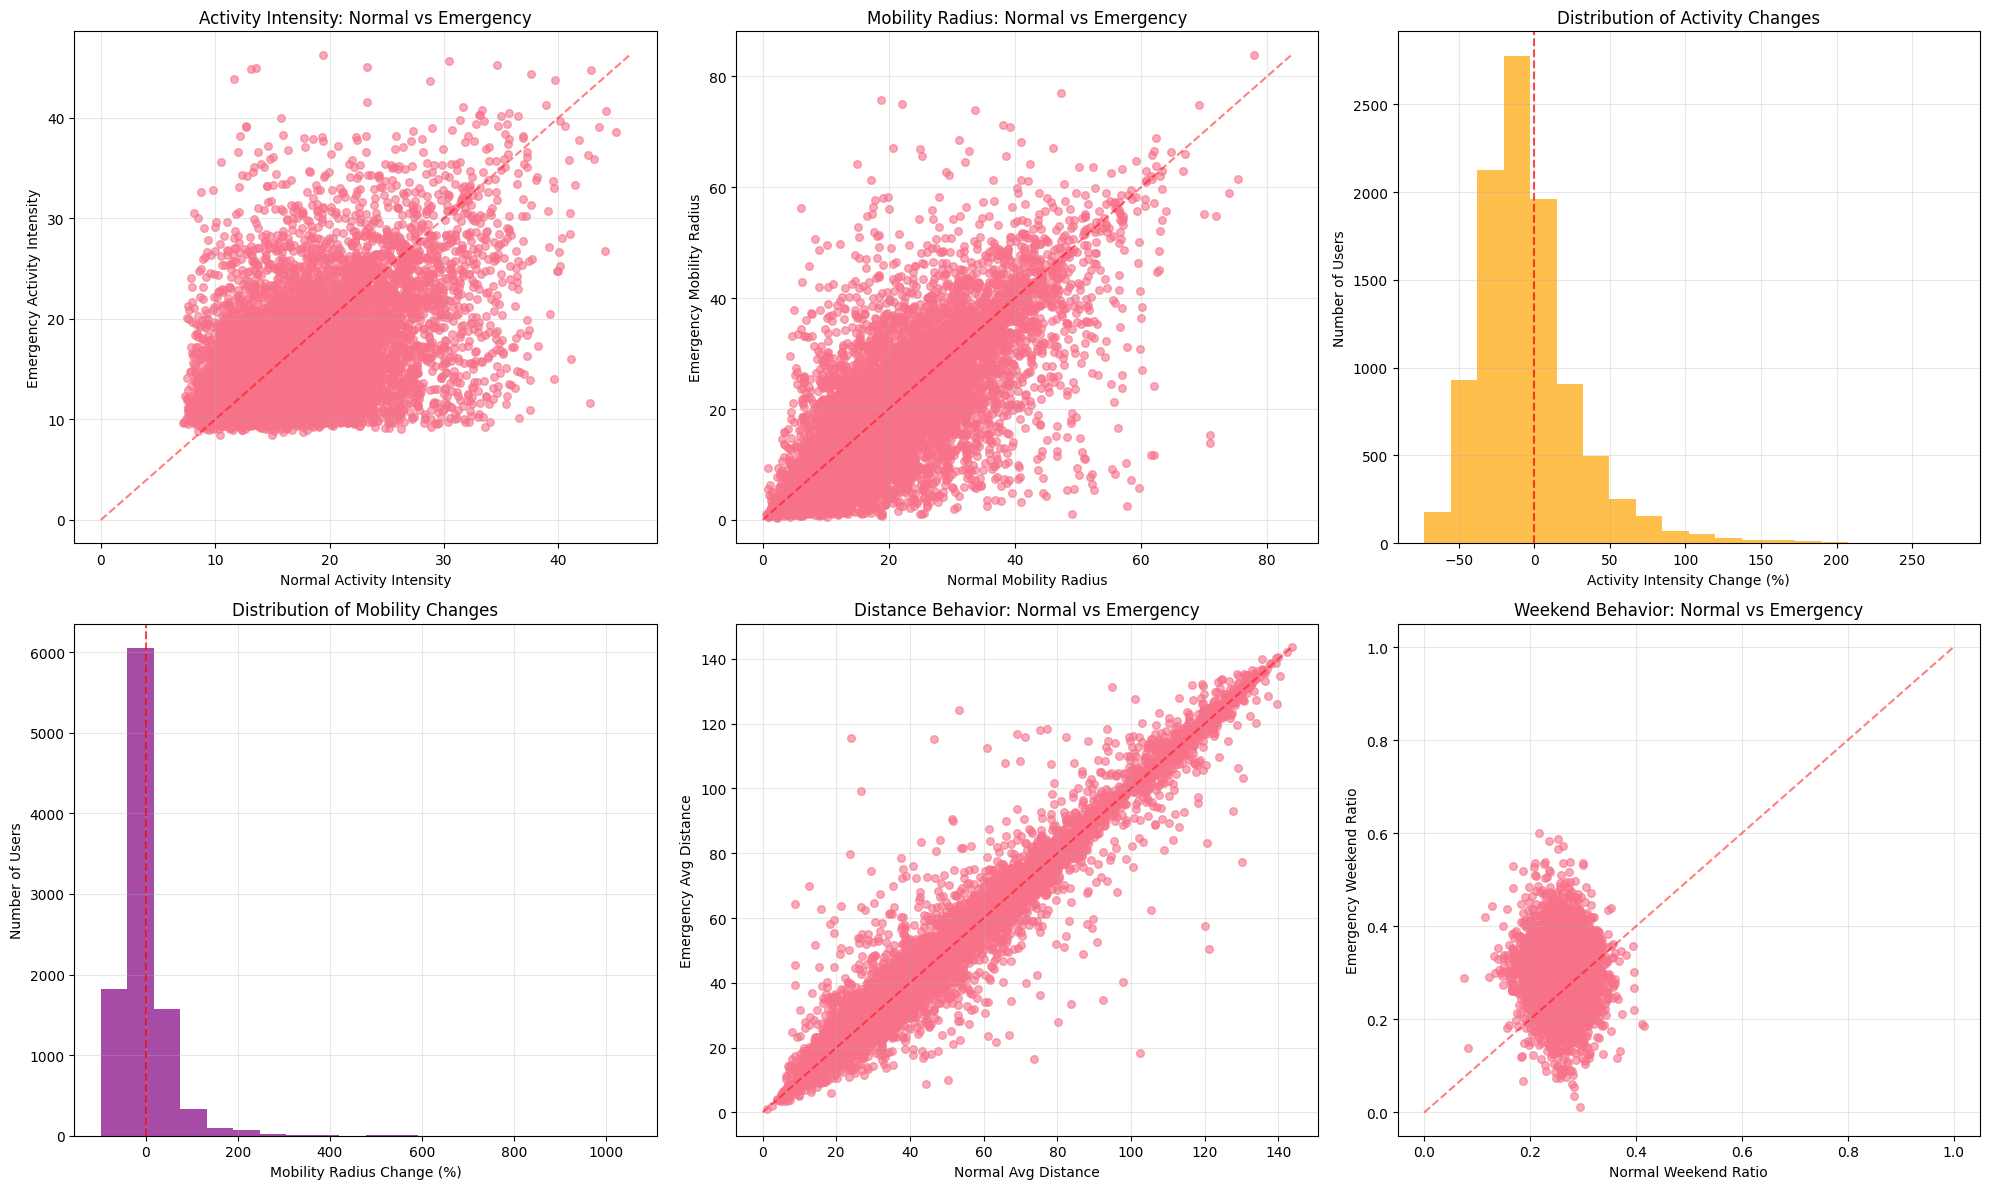


STATISTICAL TESTS (Paired, Common Users):
  Activity Intensity T-test: t=27.754, p=0.000000
  Mobility Radius T-test: t=16.953, p=0.000000
  Avg Distance T-test: t=-5.105, p=0.000000

SAVING COMPARISON RESULTS:
  Saved 'hourly_comparison.csv' - Detailed hourly pattern comparison
  Saved 'emergency_comparison_summary.json' - Overall comparison summary
  Saved 'user_behavior_changes.csv' - Individual user behavior changes
  Saved 'extreme_behavior_changes.csv' - Users with extreme changes


In [18]:
# ================================================================
# 3. USER BEHAVIOR COMPARISON
# ================================================================
print(f"\n3. USER BEHAVIOR COMPARISON")
print("-" * 30)

# Create emergency user profiles using same methodology as normal
emergency_user_profiles = emergency_data.groupby('user_id').agg({
    'day': 'nunique',                    # active_days
    'time_slot': 'count',                # total_records
    'hour': 'nunique',                   # temporal_diversity
    'grid_x': ['std', 'nunique'],        # spatial_metrics
    'grid_y': ['std', 'nunique'],        # spatial_metrics
    'distance_from_center': ['mean', 'max', 'std'], # distance_metrics
    'is_weekend': 'mean',                # weekend_activity_ratio
}).round(3)

# Flatten column names
emergency_user_profiles.columns = ['active_days', 'total_records', 'temporal_diversity',
                                  'x_std', 'x_locations', 'y_std', 'y_locations',
                                  'avg_distance', 'max_distance', 'distance_std',
                                  'weekend_ratio']

# Calculate derived metrics
emergency_user_profiles['activity_intensity'] = emergency_user_profiles['total_records'] / emergency_user_profiles['active_days']
emergency_user_profiles['mobility_radius'] = np.sqrt(emergency_user_profiles['x_std']**2 + emergency_user_profiles['y_std']**2)
emergency_user_profiles['spatial_coverage'] = emergency_user_profiles['x_locations'] * emergency_user_profiles['y_locations']

# Handle NaN values
emergency_user_profiles = emergency_user_profiles.fillna(0)

# Compare users present in both periods
common_users = list(set(user_profiles.index) & set(emergency_user_profiles.index))
print(f"Users present in both periods: {len(common_users)}")

if len(common_users) > 10:
    # Calculate changes for common users
    user_changes = pd.DataFrame(index=common_users)
    metrics = ['activity_intensity', 'mobility_radius', 'spatial_coverage', 'avg_distance', 'weekend_ratio']
    
    for metric in metrics:
        normal_values = user_profiles.loc[common_users, metric]
        emergency_values = emergency_user_profiles.loc[common_users, metric]
        
        user_changes[f'{metric}_normal'] = normal_values
        user_changes[f'{metric}_emergency'] = emergency_values
        user_changes[f'{metric}_change'] = emergency_values - normal_values
        user_changes[f'{metric}_pct_change'] = ((emergency_values - normal_values) / normal_values * 100).fillna(0)
    
    print(f"USER BEHAVIOR CHANGES (Common Users):")
    for metric in metrics:
        normal_mean = user_changes[f'{metric}_normal'].mean()
        emergency_mean = user_changes[f'{metric}_emergency'].mean()
        mean_change = user_changes[f'{metric}_change'].mean()
        pct_change = mean_change / normal_mean * 100 if normal_mean != 0 else 0
        
        print(f"  {metric.replace('_', ' ').title()}:")
        print(f"    Normal: {normal_mean:.2f} → Emergency: {emergency_mean:.2f}")
        print(f"    Change: {mean_change:.2f} ({pct_change:.1f}%)")
    
    # Visualize user behavior changes
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Activity intensity comparison
    plt.subplot(2, 3, 1)
    plt.scatter(user_changes['activity_intensity_normal'], user_changes['activity_intensity_emergency'], 
               alpha=0.6, s=30)
    max_val = max(user_changes['activity_intensity_normal'].max(), user_changes['activity_intensity_emergency'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    plt.xlabel('Normal Activity Intensity')
    plt.ylabel('Emergency Activity Intensity')
    plt.title('Activity Intensity: Normal vs Emergency')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Mobility radius comparison
    plt.subplot(2, 3, 2)
    plt.scatter(user_changes['mobility_radius_normal'], user_changes['mobility_radius_emergency'], 
               alpha=0.6, s=30)
    max_val = max(user_changes['mobility_radius_normal'].max(), user_changes['mobility_radius_emergency'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    plt.xlabel('Normal Mobility Radius')
    plt.ylabel('Emergency Mobility Radius')
    plt.title('Mobility Radius: Normal vs Emergency')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Change distributions
    plt.subplot(2, 3, 3)
    plt.hist(user_changes['activity_intensity_pct_change'], bins=20, alpha=0.7, color='orange')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Activity Intensity Change (%)')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Activity Changes')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Mobility change distributions
    plt.subplot(2, 3, 4)
    plt.hist(user_changes['mobility_radius_pct_change'], bins=20, alpha=0.7, color='purple')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Mobility Radius Change (%)')
    plt.ylabel('Number of Users')
    plt.title('Distribution of Mobility Changes')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Distance behavior changes
    plt.subplot(2, 3, 5)
    plt.scatter(user_changes['avg_distance_normal'], user_changes['avg_distance_emergency'], 
               alpha=0.6, s=30)
    max_val = max(user_changes['avg_distance_normal'].max(), user_changes['avg_distance_emergency'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    plt.xlabel('Normal Avg Distance')
    plt.ylabel('Emergency Avg Distance')
    plt.title('Distance Behavior: Normal vs Emergency')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Weekend behavior changes
    plt.subplot(2, 3, 6)
    plt.scatter(user_changes['weekend_ratio_normal'], user_changes['weekend_ratio_emergency'], 
               alpha=0.6, s=30)
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
    plt.xlabel('Normal Weekend Ratio')
    plt.ylabel('Emergency Weekend Ratio')
    plt.title('Weekend Behavior: Normal vs Emergency')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests for user behavior changes
    print(f"\nSTATISTICAL TESTS (Paired, Common Users):")
    for metric in ['activity_intensity', 'mobility_radius', 'avg_distance']:
        normal_vals = user_changes[f'{metric}_normal']
        emergency_vals = user_changes[f'{metric}_emergency']
        
        t_stat, p_val = stats.ttest_rel(normal_vals, emergency_vals)
        print(f"  {metric.replace('_', ' ').title()} T-test: t={t_stat:.3f}, p={p_val:.6f}")

# ================================================================
# 4. SAVE COMPARISON RESULTS
# ================================================================
print(f"\nSAVING COMPARISON RESULTS:")

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Create comparison summary with proper type conversion
comparison_summary = {
    'temporal': {
        'peak_shift': int(peak_shift),
        'normal_peak_hour': int(normal_peak),
        'emergency_peak_hour': int(emergency_peak),
        'peak_activity_change': float(((emergency_hourly_avg.max() - normal_hourly_avg.max())/normal_hourly_avg.max()*100)),
        'weekend_ratio_change': float(weekend_change),
        'normal_weekend_ratio': float(normal_weekend_ratio),
        'emergency_weekend_ratio': float(emergency_weekend_ratio),
        'hourly_test_pvalue': float(p_value)
    },
    'spatial': {
        'distance_change': float(distance_change),
        'distance_spread_change': float(distance_spread_change),
        'normal_avg_distance': float(normal_distances.mean()),
        'emergency_avg_distance': float(emergency_distances.mean()),
        'new_locations': int(new_emergency_locations),
        'abandoned_locations': int(abandoned_locations),
        'common_locations': int(common_locations),
        'location_stability_percent': float(common_locations/len(normal_locations)*100),
        'spatial_test_pvalue': float(p_spatial)
    },
    'dataset_info': {
        'normal_records': int(len(normal_data)),
        'emergency_records': int(len(emergency_data)),
        'normal_users': int(normal_data['user_id'].nunique()),
        'emergency_users': int(emergency_data['user_id'].nunique()),
        'common_users': int(len(common_users)),
        'normal_days': int(normal_days),
        'emergency_days': int(emergency_days)
    }
}

# Add user behavior data if available
if len(common_users) > 10:
    activity_change_mean = user_changes['activity_intensity_pct_change'].mean()
    mobility_change_mean = user_changes['mobility_radius_pct_change'].mean()
    distance_change_mean = user_changes['avg_distance_pct_change'].mean()
    
    # Identify extreme changes
    activity_threshold = 100
    mobility_threshold = 100
    
    extreme_activity_increases = user_changes[user_changes['activity_intensity_pct_change'] > activity_threshold]
    extreme_activity_decreases = user_changes[user_changes['activity_intensity_pct_change'] < -activity_threshold/2]
    extreme_mobility_increases = user_changes[user_changes['mobility_radius_pct_change'] > mobility_threshold]
    extreme_mobility_decreases = user_changes[user_changes['mobility_radius_pct_change'] < -mobility_threshold/2]
    
    comparison_summary['user_behavior'] = {
        'activity_change_mean': float(activity_change_mean),
        'mobility_change_mean': float(mobility_change_mean),
        'distance_change_mean': float(distance_change_mean),
        'extreme_activity_increases': int(len(extreme_activity_increases)),
        'extreme_activity_decreases': int(len(extreme_activity_decreases)),
        'extreme_mobility_increases': int(len(extreme_mobility_increases)),
        'extreme_mobility_decreases': int(len(extreme_mobility_decreases)),
        'total_extreme_changers': int(len(extreme_activity_increases) + len(extreme_mobility_increases)),
        'adaptation_rate_percent': float((len(extreme_activity_increases) + len(extreme_mobility_increases))/len(common_users)*100)
    }

# Convert any remaining numpy types
comparison_summary = convert_numpy_types(comparison_summary)

# Save hourly comparison data
hourly_comparison = pd.DataFrame({
    'hour': range(24),
    'normal_avg': [float(x) for x in normal_hourly_avg],
    'emergency_avg': [float(x) for x in emergency_hourly_avg],
    'pct_change': [float(x) for x in hourly_change]
})
hourly_comparison.to_csv('hourly_comparison.csv', index=False)

# Save the JSON summary
with open('emergency_comparison_summary.json', 'w') as f:
    json.dump(comparison_summary, f, indent=2)

if len(common_users) > 10:
    # Save user changes analysis
    user_changes.to_csv('user_behavior_changes.csv')
    
    # Save extreme users summary
    extreme_users_summary = pd.DataFrame({
        'category': ['Extreme Activity Increase', 'Extreme Activity Decrease', 
                    'Extreme Mobility Increase', 'Extreme Mobility Decrease'],
        'count': [len(extreme_activity_increases), len(extreme_activity_decreases),
                 len(extreme_mobility_increases), len(extreme_mobility_decreases)],
        'percentage_of_users': [
            len(extreme_activity_increases)/len(common_users)*100,
            len(extreme_activity_decreases)/len(common_users)*100,
            len(extreme_mobility_increases)/len(common_users)*100,
            len(extreme_mobility_decreases)/len(common_users)*100
        ]
    })
    extreme_users_summary.to_csv('extreme_behavior_changes.csv', index=False)

print(f"  Saved 'hourly_comparison.csv' - Detailed hourly pattern comparison")
print(f"  Saved 'emergency_comparison_summary.json' - Overall comparison summary")

if len(common_users) > 10:
    print(f"  Saved 'user_behavior_changes.csv' - Individual user behavior changes")
    print(f"  Saved 'extreme_behavior_changes.csv' - Users with extreme changes")

In [19]:
# ================================================================
# 5. COMPREHENSIVE SUMMARY
# ================================================================
print(f"\nCOMPREHENSIVE EMERGENCY vs NORMAL COMPARISON SUMMARY")
print("=" * 70)

print(f"TEMPORAL DISRUPTION:")
print(f"  Peak hour shift: {peak_shift} hours (Normal: {normal_peak}:00 → Emergency: {emergency_peak}:00)")
print(f"  Peak activity change: {((emergency_hourly_avg.max() - normal_hourly_avg.max())/normal_hourly_avg.max()*100):.1f}%")
print(f"  Weekend activity ratio change: {weekend_change:.3f} ({weekend_change/normal_weekend_ratio*100:.1f}%)")
print(f"  Circadian rhythm disruption: {'Significant' if abs(peak_shift) > 1 else 'Minimal'}")

print(f"\nSPATIAL DISRUPTION:")
print(f"  Average distance change: {distance_change:.2f} units ({distance_change/normal_distances.mean()*100:.1f}%)")
print(f"  Spatial spread change: {distance_spread_change:.2f}")
print(f"  New emergency locations: {new_emergency_locations}")
print(f"  Abandoned locations: {abandoned_locations}")
print(f"  Location stability: {common_locations/len(normal_locations)*100:.1f}%")
print(f"  Movement pattern: {'Dispersal' if distance_change > 0 else 'Concentration'}")

if len(common_users) > 10:
    print(f"\nUSER BEHAVIOR DISRUPTION:")
    print(f"  Average activity intensity change: {activity_change_mean:.1f}%")
    print(f"  Average mobility radius change: {mobility_change_mean:.1f}%")
    print(f"  Average distance preference change: {distance_change_mean:.1f}%")
    print(f"  Users with extreme activity changes: {len(extreme_activity_increases) + len(extreme_activity_decreases)}")
    print(f"  Users with extreme mobility changes: {len(extreme_mobility_increases) + len(extreme_mobility_decreases)}")
    print(f"  Behavioral adaptation rate: {(len(extreme_activity_increases) + len(extreme_mobility_increases))/len(common_users)*100:.1f}%")

print(f"\nSTATISTICAL SIGNIFICANCE:")
print(f"  Hourly pattern change: {'Significant' if p_value < 0.05 else 'Not significant'} (p={p_value:.6f})")
print(f"  Spatial distribution change: {'Significant' if p_spatial < 0.05 else 'Not significant'} (p={p_spatial:.6f})")

print(f"\nEMERGENCY RESPONSE INSIGHTS:")
print(f"  Response time: Activity patterns changed immediately at day 61")
print(f"  Adaptation type: {'Rapid behavioral shift' if abs(peak_shift) > 2 else 'Gradual adjustment'}")
if len(common_users) > 10:
    print(f"  Population resilience: {'High' if len(extreme_activity_increases) > len(extreme_activity_decreases) else 'Moderate'}")
print(f"  Spatial behavior: {'Evacuation pattern' if distance_change > 5 else 'Local adaptation'}")

print(f"\nANALYSIS COMPLETE!")
print(f"Comprehensive emergency vs normal behavior comparison finished!")
print(f"All results saved for further analysis and publication")
print(f"Ready for advanced analysis or emergency response planning")



COMPREHENSIVE EMERGENCY vs NORMAL COMPARISON SUMMARY
TEMPORAL DISRUPTION:
  Peak hour shift: 0 hours (Normal: 17:00 → Emergency: 17:00)
  Peak activity change: -4.3%
  Weekend activity ratio change: 0.043 (16.8%)
  Circadian rhythm disruption: Minimal

SPATIAL DISRUPTION:
  Average distance change: 0.24 units (0.5%)
  Spatial spread change: 0.00
  New emergency locations: 817
  Abandoned locations: 3977
  Location stability: 85.1%
  Movement pattern: Dispersal

USER BEHAVIOR DISRUPTION:
  Average activity intensity change: -4.1%
  Average mobility radius change: -2.8%
  Average distance preference change: 1.9%
  Users with extreme activity changes: 475
  Users with extreme mobility changes: 1564
  Behavioral adaptation rate: 5.0%

STATISTICAL SIGNIFICANCE:
  Hourly pattern change: Not significant (p=0.642595)
  Spatial distribution change: Significant (p=0.000000)

EMERGENCY RESPONSE INSIGHTS:
  Response time: Activity patterns changed immediately at day 61
  Adaptation type: Gradual 